In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from tqdm.auto import tqdm
from scipy.special import logit,expit

from src.IterativeFitting import IterativeFitting as IF
from src.CorrFuncs import covariance_matrix, trend_est

In [464]:
# Setting seed
golden_seed = 6
seed = 8
np.random.seed(seed)

# Initializing simulation slope and intercept parameters
beta0 = -0.1
beta1 = 0.02
beta_age = 0.05
beta_income = -0.05
beta_sex = 1.0

# Number of samples
n = 40000

# Constructing covariate vectors for additional covariates to adjust
age_vector = np.random.uniform(low=0,high=1,size=n)
income_vector = np.random.uniform(low=0,high=1,size=n)
# sex_vector = np.random.binomial(n=1,p=0.6,size=n)

# Assigning exposure levels and getting relevant x's
exposure_levels = np.array([0.,1.,2.,3.])
xs = np.random.choice(exposure_levels,size = n)
sex_vector = np.random.binomial(n = 1,p = 0.1 + xs/4,size =n )


# Function to generate probabilities of being a case v non-case
other_covs = beta0 + (beta_age*age_vector) + (income_vector*beta_income) + (sex_vector*beta_sex) 
p = lambda x: (np.exp(beta1*x + other_covs))/(1 + np.exp(beta1*x + other_covs))

# Actually calculating probabilities on exposures as defined
px = p(xs)

# Actually assigning to case or not
outcomes = np.array([np.random.binomial(n=1,p=p,size=1)[0] for p in px])

# Constructing and sorting dataframe of outcomes and exposure
df = np.stack([outcomes,xs],axis=1)
# df = df[np.argsort(df[:, 1])]

# Getting xs corresponding to each exposure interval and corresponding case information
categories = [df[np.where(df[:,1] == i)[0]] for i in exposure_levels]
N = np.array([df.shape[0] for df in categories])
cases = np.array([np.sum(df[:,0]) for df in categories])
non_cases = N - cases
a_0, A = cases[0], cases[1:]
b_0, B = non_cases[0], non_cases[1:]
M = np.sum(cases)

# Getting crude estimates to compare
crude = lambda x,y: (x/y) / (a_0/b_0)
crudeors = crude(A,B)

# Constructing dummy variables with respect to exposure level
x = exposure_levels[1:]

to_adjust_df = pd.DataFrame({
    'age':age_vector,
    'income':income_vector,
    'sex':sex_vector,
    'exposure':xs.astype(int)
})
to_adjust_df['intercept']=1

to_adjust_df = pd.concat([to_adjust_df,pd.get_dummies(to_adjust_df['exposure'],prefix='exposure').astype(int).iloc[:,1:]],axis=1).drop('exposure',axis=1)

results = sm.Logit(endog=df[:,0], exog=to_adjust_df).fit()
true_C = results.cov_params().to_numpy()[4:,4:]
true_C_inv = np.linalg.inv(true_C)

# Get log-ORs and corresponding variances
L = results.params.to_numpy()[4:]
v = (results.bse.to_numpy()[4:])**2

Optimization terminated successfully.
         Current function value: 0.645992
         Iterations 5


In [465]:
np.exp(L)

array([0.99795593, 1.0243074 , 1.04804608])

In [466]:
crudeors

array([1.2551063 , 1.64324092, 2.17078667])

In [467]:
# Running GL
it_fit_ex = IF(L,A,N,M)
Ap, Bp, a0p, b0p = it_fit_ex.convexProgram()

C = covariance_matrix(Ap,Bp,a0p,b0p,v)
inv_C = np.linalg.inv(C)

In [468]:
# Recovering slope estimate for corrected correlation
vb_star = 1 / (x.T@inv_C@x)
b_star = vb_star*(x.T@inv_C@L)
b_star

0.016390360054777876

In [469]:
# Recovering standard slope estimate
vb = 1/(np.dot(x,np.dot(np.linalg.inv(np.diag(v)),x)))
b = vb*(np.dot(x,np.dot(np.linalg.inv(np.diag(v)),L)))
b

0.01281627465337195

In [470]:
rootWols = np.diag(1/np.sqrt(v))
X_intercept_ols = np.vstack([np.ones(len(x)),x]).T
intercept_ols_slope = np.linalg.lstsq(rootWols@X_intercept_ols,rootWols@L,rcond = 1e-15)[0][1]
intercept_ols_slope

0.024585115874140674

In [471]:
# Getting Oracle estimates
vb_oracle = 1/(np.dot(x,np.dot(true_C_inv,x)))
b_oracle = vb_oracle*(np.dot(x,np.dot(true_C_inv,L)))
b_oracle

0.01633161515485301

In [472]:
# Getting estimates from covariance matrix generated from raw counts
C_raw = covariance_matrix(A,B,a_0,b_0,v)
inv_C_raw = np.linalg.inv(C_raw)

vb_r = 1/(x.T@inv_C_raw@x)
b_r = vb_r*(x.T@inv_C_raw@L)
b_r

0.016216320901233153

In [473]:
x_valsp = np.hstack([0,x])
plt.scatter(x,L,alpha=0.5,c="rebeccapurple",s=100)
plt.scatter(0,0,s=50,c="forestgreen")
plt.plot(x_valsp,b_star*x_valsp,label = 'GL',linestyle = 'dashed')
plt.plot(x_valsp,b_oracle*x_valsp,label = 'Oracle_Cov', alpha = 0.5,lw = 5)
plt.plot(x_valsp,beta1*x_valsp,label = 'Truth',c="cornflowerblue",linestyle="dashdot")
plt.plot(x_valsp,b_r*x_valsp,label="Crude",c="maroon",lw = 5,alpha = 0.5)
plt.plot(x_valsp,intercept_ols_slope*x_valsp,label="Intercept",c="lightsteelblue")
plt.plot(x_valsp,b*x_valsp,label = "OLS")
plt.legend()

In [27]:
GL_pe_list = []
GL_v_list = []
oracle_pe_list = []
oracle_v_list = []
OLS_pe_list = []
OLS_v_list = []
crude_pe_list = []
crude_v_list = []

crude_cov = []
gl_cov = []
oracle_cov = []

# Setting seed
golden_seed = 6
seed = 8
np.random.seed(seed)

# Initializing simulation slope and intercept parameters
beta0 = -0.1
beta1 = 0.02
beta_age = 1.
beta_income = -0.05
beta_sex = 5.0

# Number of samples
n = 10000

# Simulation number
sim_no = 1000

for i in tqdm(range(sim_no)):
    # Constructing covariate vectors for additional covariates to adjust
    age_vector = np.random.uniform(low=0,high=1,size=n)
    income_vector = np.random.uniform(low=0,high=1,size=n)
    # sex_vector = np.random.binomial(n=1,p=0.6,size=n)

    # Assigning exposure levels and getting relevant x's
    exposure_levels = np.array([0.,1.,2.,3.])
    xs = np.random.choice(exposure_levels,size = n,p = np.array([0.04,0.32,0.32,0.32]))
    sex_vector = np.random.binomial(n = 1,p = 0.1 + xs/4,size =n )


    # Function to generate probabilities of being a case v non-case
    other_covs = beta0 + (beta_age*age_vector) + (income_vector*beta_income) + (sex_vector*beta_sex) 
    #p = lambda x: (np.exp(beta1*x + other_covs))/(1 + np.exp(beta1*x + other_covs))
    px = (expit(beta1*xs+other_covs))

    # Actually calculating probabilities on exposures as defined
    #px = p(xs)

    # Actually assigning to case or not
    outcomes = np.array([np.random.binomial(n=1,p=p,size=1)[0] for p in px])

    # Constructing and sorting dataframe of outcomes and exposure
    df = np.stack([outcomes,xs],axis=1)
    # df = df[np.argsort(df[:, 1])]

    # Getting xs corresponding to each exposure interval and corresponding case information
    categories = [df[np.where(df[:,1] == i)[0]] for i in exposure_levels]
    N = np.array([df.shape[0] for df in categories])
    cases = np.array([np.sum(df[:,0]) for df in categories])
    non_cases = N - cases
    a_0, A = cases[0], cases[1:]
    b_0, B = non_cases[0], non_cases[1:]
    M = np.sum(cases)

    # Getting crude estimates to compare
    crude = lambda x,y: (x/y) / (a_0/b_0)
    crudeors = crude(A,B)

    # Constructing dummy variables with respect to exposure level
    x = exposure_levels[1:]

    to_adjust_df = pd.DataFrame({
        'age':age_vector,
        'income':income_vector,
        'sex':sex_vector,
        'exposure':xs.astype(int)
    })
    to_adjust_df['intercept']=1

    to_adjust_df = pd.concat([to_adjust_df,pd.get_dummies(to_adjust_df['exposure'],prefix='exposure').astype(int).iloc[:,1:]],axis=1).drop('exposure',axis=1)

    results = sm.Logit(endog=outcomes, exog=to_adjust_df).fit(disp=0)
    num_exposures = len(exposure_levels)-1
    true_C = results.cov_params().to_numpy()[-num_exposures:,-num_exposures:]
    true_C_inv = np.linalg.inv(true_C)

    # Get log-ORs and corresponding variances
    L = results.params.to_numpy()[-num_exposures:]
    v = (results.bse.to_numpy()[-num_exposures:])**2

    # Running GL
    it_fit_ex = IF(L,A,N,M)
    Ap, Bp, a0p, b0p = it_fit_ex.convexProgram()

    C = covariance_matrix(Ap,Bp,a0p,b0p,v)
    inv_C = np.linalg.inv(C)
    gl_cov.append(C)
    
    

    # Recovering slope estimate for corrected correlation
    vb_star = 1 / (x.T@inv_C@x)
    b_star = vb_star*(x.T@inv_C@L)
    GL_pe_list.append(b_star)
    GL_v_list.append(vb_star)

    # Recovering OLS estimates
    vb = 1/(x.T@(np.diag(1/v))@x)
    b = vb*(x.T@np.diag(1/v)@L)

    # vb = 1/(np.dot(x,np.dot(np.linalg.inv(np.diag(v)),x)))
    # b = vb*(np.dot(x,np.dot(np.linalg.inv(np.diag(v)),L)))
    OLS_pe_list.append(b)
    OLS_v_list.append(vb)

    # Getting Oracle estimates
    vb_oracle = 1/(x.T@true_C_inv@x)
    oracle_cov.append(true_C)

    #vb_oracle = 1/(np.dot(x,np.dot(true_C_inv,x)))
    b_oracle = vb_oracle*(x.T@true_C_inv@L)
    # b_oracle = vb_oracle*(np.dot(x,np.dot(true_C_inv,L)))
    oracle_pe_list.append(b_oracle)
    oracle_v_list.append(vb_oracle)

    # Getting estimates from covariance matrix generated from raw counts
    C_raw = covariance_matrix(A,B,a_0,b_0,v)
    inv_C_raw = np.linalg.inv(C_raw)
    crude_cov.append(C_raw)

    vb_r = 1/(x.T@inv_C_raw@x)
    b_r = vb_r*(x.T@inv_C_raw@L)
    crude_pe_list.append(b_r)
    crude_v_list.append(vb_r)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [34]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9993
Method:                           MLE   Df Model:                            6
Date:                Thu, 13 Jun 2024   Pseudo R-squ.:                  0.3536
Time:                        18:59:41   Log-Likelihood:                -2902.2
converged:                       True   LL-Null:                       -4490.0
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
age            0.9747      0.110      8.890      0.000       0.760       1.190
income         0.0089      0.110      0.081      0.936      -0.207       0.225
sex            5.0942      0.210     24.223      0.000       4.682       5.506
intercept     -0.0524      0.130     -0.402      0.688      -0.308       0.203
exposure_1     0.0076      0.115      0.066      0.948      -0.218       0.233
exposure_2    -0.0067      0.120     -0.056      0.955      -0.242       0.229
exposure_3    -0.0154      0.141     -0.109      0.913      -0.291       0.260
==============================================================================
"""

In [18]:
variance_estimates = pd.DataFrame({"OLS": OLS_v_list,
'GL':GL_v_list,
"Oracle":oracle_v_list,
"Crude":crude_v_list}
)
variance_estimates


,OLS,GL,Oracle,Crude
0,0.001255,0.001058,0.001528,0.001417
1,0.001300,0.000951,0.001513,0.001374
2,0.001232,0.000972,0.001470,0.001347
3,0.001305,0.001114,0.001572,0.001461
4,0.001191,0.001119,0.001497,0.001398
...,...,...,...,...
995,0.001317,0.001023,0.001572,0.001435
996,0.001310,0.001066,0.001556,0.001440
997,0.001183,0.001027,0.001475,0.001364
998,0.001276,0.001039,0.001552,0.001437


In [33]:
((point_estimates-beta1)*(point_estimates-beta1)).mean()

GL        0.002161
Oracle    0.001715
OLS       0.003012
Crude     0.001738
dtype: float64

In [19]:
point_estimates = pd.DataFrame(
    {
        'GL':GL_pe_list,
        "Oracle":oracle_pe_list,
        "OLS":OLS_pe_list,
        "Crude":crude_pe_list,
    }
)

#point_estimates['truth']=beta1

In [20]:
std_estimate = point_estimates.std(axis=0)
std_estimate['OLS']/std_estimate['GL']

1.1797253568909316

In [21]:
std_estimate

GL        0.046487
Oracle    0.041427
OLS       0.054842
Crude     0.041705
dtype: float64

In [22]:
((point_estimates - beta1)/np.sqrt(variance_estimates)).std()

Crude     1.112596
GL        1.447118
OLS       1.536448
Oracle    1.060044
dtype: float64

In [10]:
point_estimates.mean(axis=0) + 2 * point_estimates.sem(axis=0)

GL        0.021648
Oracle    0.019904
OLS       0.017934
Crude     0.019277
dtype: float64

In [11]:
point_estimates.mean(axis=0) - 2 * point_estimates.sem(axis=0)

GL        0.018229
Oracle    0.016509
OLS       0.011894
Crude     0.015865
dtype: float64

In [ ]:
point_estimates.mean(axis=0)


GL        0.020165
Oracle    0.020184
OLS       0.020200
Crude     0.020156
truth     0.020000
dtype: float64

In [ ]:
GL_pe_list = []
GL_v_list = []
oracle_pe_list = []
oracle_v_list = []
OLS_pe_list = []
OLS_v_list = []
crude_pe_list = []
crude_v_list = []


In [ ]:
b_star = np.mean(GL_pe_list)
b = np.mean(OLS_pe_list)
b_oracle = np.mean(oracle_pe_list)
b_r = np.mean(crude_pe_list)

In [ ]:
vb_star = np.mean(GL_v_list)
vb = np.mean(OLS_v_list)
vb_oracle = np.mean(oracle_v_list)
vb_r = np.mean(crude_v_list)

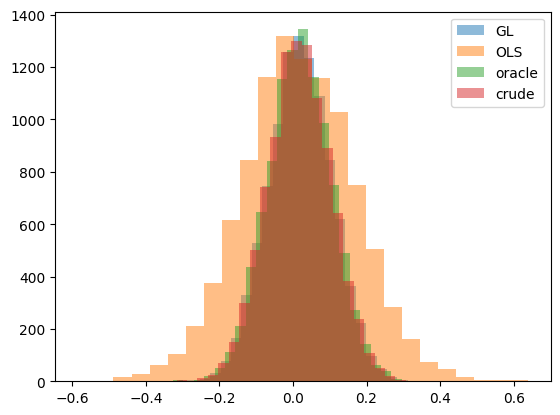

In [ ]:
nbins = 25
plt.hist(GL_pe_list,bins=nbins, alpha=0.5, label="GL")
plt.hist(OLS_pe_list,bins=nbins, alpha=0.5, label="OLS")
plt.hist(oracle_pe_list,bins=nbins, alpha=0.5, label="oracle")
plt.hist(crude_pe_list,bins=nbins,alpha=0.5, label="crude")
plt.legend()

In [ ]:
np.var(GL_pe_list)

0.0001243123590894898

In [ ]:
np.var(OLS_pe_list)

0.00012427179561154875

In [35]:
vb_star

0.0010261992125900105

In [36]:
vb

0.001238800550365713

In [37]:
vb_oracle

0.001533356845294936

In [38]:
vb_r

0.0014090176552138517

In [39]:
crude_cov[-1]

array([[0.01320376, 0.01160751, 0.01219727],
       [0.01160751, 0.01444179, 0.01241576],
       [0.01219727, 0.01241576, 0.019801  ]])

In [40]:
gl_cov[-1]

array([[0.01320376, 0.01225246, 0.01432128],
       [0.01225246, 0.01444179, 0.01499722],
       [0.01432128, 0.01499722, 0.019801  ]])

In [41]:
oracle_cov[-1]

array([[0.01320376, 0.01113691, 0.01116454],
       [0.01113691, 0.01444179, 0.01123023],
       [0.01116454, 0.01123023, 0.019801  ]])

In [42]:
np.mean(crude_cov)

0.013867715241838649

In [49]:
np.mean(crude_cov,axis=0)

array([[0.01378708, 0.01219672, 0.01274732],
       [0.01219672, 0.01503073, 0.01295279],
       [0.01274732, 0.01295279, 0.02019798]])

In [50]:
np.mean(gl_cov,axis=0)

array([[0.01378708, 0.01277598, 0.01479449],
       [0.01277598, 0.01503073, 0.01543366],
       [0.01479449, 0.01543366, 0.02019798]])

In [51]:
np.mean(oracle_cov,axis=0)

array([[0.01378708, 0.01177801, 0.01180128],
       [0.01177801, 0.01503073, 0.01186986],
       [0.01180128, 0.01186986, 0.02019798]])